In [1]:
import numpy as np
import cv2
import glob
from os import path
from functions import *
from matplotlib import pyplot as plt
from itertools import count

In [2]:
CAMERA_ID = 'david'
SESSION_ID = '13-04-2021b'
PROCESSED_TARGET_OBJECT_IMAGE_NAME = 'result_247_247_4_7.png'
BASE_PLANE_POINTS_IMAGE_NAME = 'result_231_233_5_8-clean-clean.png'
ELEVATED_PLANE_POINTS_IMAGE_NAME = 'intrujice.png'
CHESSBOARD_SQUARE_LENGTH_MM = 1
CHESSBOARD_DIMENSIONS = (9,6, CHESSBOARD_SQUARE_LENGTH_MM)
PLANE_CALIBRATION_OBJECT_HEIGHT_MM = 2 * CHESSBOARD_SQUARE_LENGTH_MM

## Intrinsic parameter calibration

In [3]:
object_points, image_points, image_dimensions = chessboardPointExtraction(CHESSBOARD_DIMENSIONS,f'data/calibration/{CAMERA_ID}/intrinsic')
ret, intrinsic_matrix, distortion_coefs, rotation_vecs, translation_vecs = cv2.calibrateCamera(object_points, image_points, image_dimensions,None,None)
print('\nImage Dimensions\n', image_dimensions)
print('\nIntrinsic Matrix\n', intrinsic_matrix)
print('\nDistortion Coefficients\n', distortion_coefs)
print(f'\nReprojection error: {calculateReprojectionError(object_points, image_points, rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)}')

100%|██████████| 20/20 [00:08<00:00,  2.30it/s]

Calibration over

Image Dimensions
 (1280, 720)

Intrinsic Matrix
 [[9.95501372e+02 0.00000000e+00 6.59362831e+02]
 [0.00000000e+00 1.00107125e+03 3.60433164e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients
 [[ 0.27103847 -0.58181555 -0.02118469  0.00707566  0.56085949]]

Reprojection error: 0.04925399363823912


## Extrinsic parameter calibration

In [4]:
object_points, image_points, _ = chessboardPointExtraction(CHESSBOARD_DIMENSIONS, f'data/calibration/{CAMERA_ID}/{SESSION_ID}/extrinsic')
object_points_reshaped = np.array(object_points).reshape((-1,3))
image_points_reshaped = np.array(image_points).reshape((-1,2))

# Calculate extrinsic parameter matrices (translation and rotation) using PNP RANSAC
ret, rotation_vecs, translation_vecs, _ = cv2.solvePnPRansac(object_points_reshaped, image_points_reshaped, intrinsic_matrix, distortion_coefs)
print(f'Reprojection error: {calculateReprojectionError(object_points, image_points, rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)}')

100%|██████████| 20/20 [00:00<00:00, 45.53it/s]
Calibration over
Reprojection error: 0.9771486339952883



## Projection Calculation

In [5]:
perspective_projection_matrix = calculatePpmMatrix(intrinsic_matrix, rotation_vecs, translation_vecs)

## Shadow/Light Plane Calibration

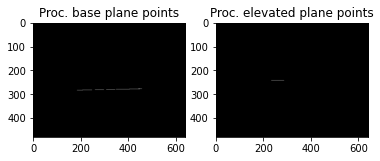

In [6]:
session_path = f'data/calibration/{CAMERA_ID}/{SESSION_ID}/'

base_plane_points_capture = cv2.imread(f'{session_path}/base_plane_points/{BASE_PLANE_POINTS_IMAGE_NAME}',cv2.IMREAD_GRAYSCALE)
elevated_plane_points_capture = cv2.imread(f'{session_path}/elevated_plane_points/{ELEVATED_PLANE_POINTS_IMAGE_NAME}',cv2.IMREAD_GRAYSCALE)

# TODO: Perhaps put image processing here, right now we are fetching the processed images

processed_base_plane_points = base_plane_points_capture
processed_elevated_plane_points = elevated_plane_points_capture

_, subplots = plt.subplots(1,2)
subplots[0].set_title('Proc. base plane points')
subplots[0].imshow(processed_base_plane_points, cmap='gray')

subplots[1].set_title('Proc. elevated plane points')
subplots[1].imshow(processed_elevated_plane_points, cmap='gray')

In [7]:
# 'Floor' points
base_points = getWhitePoint3DCoords(processed_base_plane_points, [[0,0,1,0]], perspective_projection_matrix)

# Object top points
elevated_points = getWhitePoint3DCoords(processed_elevated_plane_points, [[0,0,1,PLANE_CALIBRATION_OBJECT_HEIGHT_MM]], perspective_projection_matrix)

# This section reduces the number of base plane points. This is done because if the number of base points is too large compared with the elevated points, the RANSAC algorithm may consider them as outliers.
y_min = np.min(elevated_points[:,1])
y_max = np.max(elevated_points[:,1])
filtered_base_points_index = np.where((base_points[:,1] >= y_min) & (base_points[:,1] <= y_max))
filtered_base_points =  base_points[filtered_base_points_index]

plane_3d_points = list(filtered_base_points)
plane_3d_points.extend(elevated_points)

In [8]:
# Calculate plane coeficients
plane_coefs = calculatePlaneCoefs(np.array(plane_3d_points))
plane_coefs

[-4.96049422866281, 0.31918004928496124, -1.0, 2.4110041708316174]

## Target object point extraction

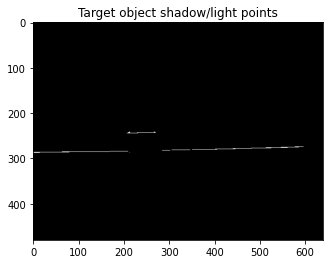

In [9]:
target_object_points = cv2.imread(f'data/calibration/{CAMERA_ID}/{SESSION_ID}/cube_processed/{PROCESSED_TARGET_OBJECT_IMAGE_NAME}')
target_object_points_gray = cv2.cvtColor(target_object_points, cv2.COLOR_BGR2GRAY)

# TODO: Perhaps put image processing here, right now we are fetching the processed images

plt.title('Target object shadow/light points')
plt.imshow(target_object_points, cmap='gray')

In [10]:
# Calculate y and z for points in shadow
points = getWhitePoint3DCoords(target_object_points_gray, [plane_coefs], perspective_projection_matrix)

points_x = [point[0] for point in points]
points_y = [point[1] for point in points]
points_z = [point[2] for point in points]


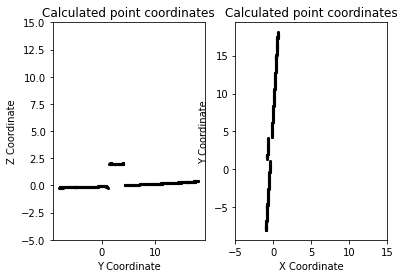

In [11]:
figure, subplots = plt.subplots(1, 2)
subplots[0].set_title('Calculated point coordinates')
subplots[0].set_xlabel('Y Coordinate')
subplots[0].set_ylabel('Z Coordinate')
subplots[0].set_ylim([-5,15])
subplots[0].scatter(points_y, points_z, color='black', marker='.', linewidths=0.1)

subplots[1].set_title('Calculated point coordinates')
subplots[1].set_xlabel('X Coordinate')
subplots[1].set_ylabel('Y Coordinate')
subplots[1].set_xlim([-5,15])
subplots[1].scatter(points_x, points_y, color='black', marker='.', linewidths=0.1)